In [1]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# tensorflow and sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# importing models and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('TensorFlow_FILES/DATA/lending_club_loan_two.csv')
df_info=pd.read_csv('TensorFlow_FILES/DATA/lending_club_info.csv')

In [3]:
df_info=pd.read_csv('TensorFlow_FILES/DATA/lending_club_info.csv')

In [4]:
%pprint

Pretty printing has been turned OFF


In [5]:
df_info

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when ap...
7,emp_length,Employment length in years. Possible values ar...
8,home_ownership,The home ownership status provided by the borr...
9,annual_inc,The self-reported annual income provided by th...


In [6]:
pd.options.display.max_colwidth = 500

In [7]:
df_info[df_info.LoanStatNew == 'initial_list_status']['Description']

24    The initial listing status of the loan. Possible values are – W, F
Name: Description, dtype: object

In [8]:
df_info[df_info.LoanStatNew == 'application_type']['Description']

25    Indicates whether the loan is an individual application or a joint application with two co-borrowers
Name: Description, dtype: object

In [9]:
df['application_type'].unique()

array(['INDIVIDUAL', 'JOINT', 'DIRECT_PAY'], dtype=object)

In [10]:
df.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"


- get rid of some high NaN but low utility columns like title, emp_title
- change some of the columns like 
- extrapolate fills for revol

emp_title               22927 kill - too many null to be useful X
emp_length              18301 fill
title                    1755 kill - not sure how it would be useful X
revol_util                276 small number - use mean?
mort_acc                37795 mostly empty X
pub_rec_bankruptcies      535 update na to 0 X

### EDA viz

In [11]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [12]:
df[df.loan_status == 'Charged Off'].loan_status.count()

77673

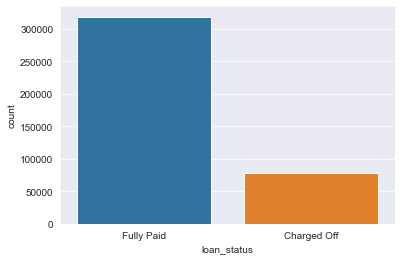

In [13]:
sns.countplot(df.loan_status)

In [14]:
df[df.loan_amnt > 0]['loan_amnt'][:10]

0    10000.0
1     8000.0
2    15600.0
3     7200.0
4    24375.0
5    20000.0
6    18000.0
7    13000.0
8    18900.0
9    26300.0
Name: loan_amnt, dtype: float64

In [15]:
# plt.figure(figsize=(8,5))
# sns.distplot(df[df.loan_amnt > 0]['loan_amnt'])

In [16]:
df.grade.unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [17]:
df.grade.value_counts()

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

In [18]:
df.sub_grade.unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

In [19]:
df[df.grade != 0][:3]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"


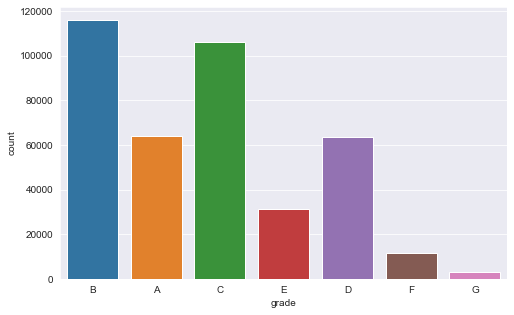

In [20]:
plt.figure(figsize=(8,5))
#sns.countplot(df[df.grade != 0]['grade'])
sns.countplot(df.grade)

In [21]:
df.sub_grade.value_counts()

B3    26655
B4    25601
C1    23662
C2    22580
B2    22495
B5    22085
C3    21221
C4    20280
B1    19182
A5    18526
C5    18244
D1    15993
A4    15789
D2    13951
D3    12223
D4    11657
A3    10576
A1     9729
D5     9700
A2     9567
E1     7917
E2     7431
E3     6207
E4     5361
E5     4572
F1     3536
F2     2766
F3     2286
F4     1787
F5     1397
G1     1058
G2      754
G3      552
G4      374
G5      316
Name: sub_grade, dtype: int64

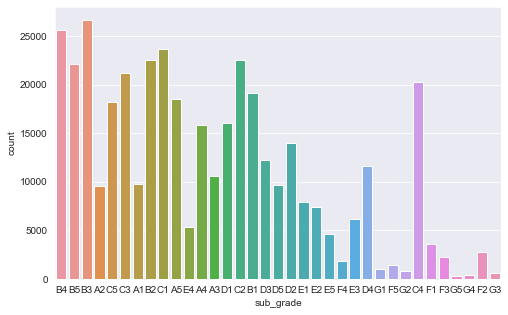

In [22]:
plt.figure(figsize=(8,5))
#sns.countplot(df[df.grade != 0]['grade'])
sns.countplot(df.sub_grade)

### correlation analysis

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


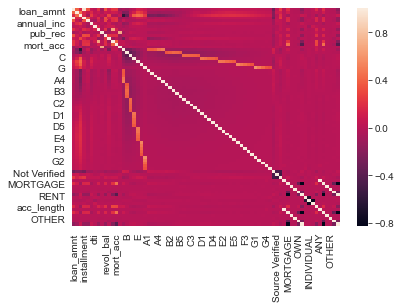

In [137]:
sns.heatmap(df.corr())

### Data cleaning

In [25]:
# get a count of nulls per column - need to scrub out categories before I can use fillna()
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

#### Drops


In [26]:
# consolidated drops - this tanks ram and kills the kernal
# df.drop(['title','purpose','emp_title'],axis=1, inplace=True)

In [27]:
df = df.drop(['title'],axis=1)

In [28]:
df = df.drop(['purpose'],axis=1)

In [29]:
df =  df.drop(['emp_title'],axis=1)

In [30]:
df = df.drop(['initial_list_status'],axis=1)

In [31]:
# if null, no bankruptcies
df[df.pub_rec_bankruptcies.isnull()] = 0

#### fixing columns that have numbers and nulls

In [32]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
application_type            0
mort_acc                37260
pub_rec_bankruptcies        0
address                     0
dtype: int64

In [33]:
df.revol_bal = df.revol_bal.apply(lambda x: x if isinstance(x,float) else x if isinstance(x,int) else 0)

In [34]:
df.mort_acc = df.mort_acc.apply(lambda x: x if isinstance(x,float) else x if isinstance(x,int) else 0)

In [35]:
df.mort_acc = df.mort_acc.fillna(0)
df.mort_acc = df.mort_acc.apply(lambda x: x if isinstance(x,float) else x if isinstance(x,int) else 0)

In [36]:
df.revol_util = df.revol_util.fillna(0)

#### get a list of columns that have NaNs

everything left should be numbers that can have zeroes.

In [37]:
nan_values = df.isna()
nan_columns = nan_values.any()
columns_with_nan = df.columns[nan_columns].tolist()
columns_with_nan

['emp_length']

In [38]:
df[columns_with_nan] = df[columns_with_nan].fillna(0)

#### turn employment length into a number

In [39]:
def employ(x):
    if x is not None:
        if isinstance(x,float) or isinstance(x,int):
            return x
        elif '10+' in x:
            return 10
        elif '<' in x:
            return 1
        else:
            return x
    else:
        return 0
    

In [40]:
df.emp_length = df.emp_length.apply(employ)

In [41]:
# first break out the string
df.emp_length = df.emp_length.apply(lambda x: x.split(' ')[0] if isinstance(x, str) else x)

In [42]:
#df.emp_length.apply(lambda x: x.split('+')[0] if '+' in x else x)

#### reset term to just be a number

In [43]:
df.term[:3]

0     36 months
1     36 months
2     36 months
Name: term, dtype: object

In [44]:
df['term'].iloc[10].split(' ')[1]

'36'

In [45]:
def term(x):
    if x != 0:
        return int(x.split(' ')[1])
    else: 
        return int(0)

In [46]:
df.term = df.term.apply(term)

### Fixing Categores with Dummies

#### using drop first with dummies
not duplicating information - want to change Categories to either numeric or boolean. 


when encoding M/F you don't want to end up with M and F, you want it to be a Male Boolean M 0 or 1

if A/B/C you don't want A, B and C columns - Boolean A or B and if not, then C



In [47]:
pd.get_dummies(df['grade'])[:3]

,0,A,B,C,D,E,F,G
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0


In [48]:
grade_dummies = pd.get_dummies(df['grade'],drop_first=True)

In [49]:
df  = pd.concat([df.drop('grade',axis=1),grade_dummies],axis=1)

In [50]:
pd.get_dummies(df['sub_grade'])[:3]

,0,A1,A2,A3,A4,A5,B1,B2,B3,B4,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
sub_grade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)

In [52]:
df  = pd.concat([df.drop('sub_grade',axis=1),sub_grade_dummies],axis=1)

In [53]:
# how many loan amounts are zero?
df[df.loan_amnt < 1]['loan_amnt'].count() 

535

In [54]:
df.loan_amnt.count() - df[df.loan_amnt < 1]['loan_amnt'].count() 

395495

In [55]:
# what categories are left?
# drop all the loan amount == 0 
df[df.loan_amnt > 0].head(3)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,10000.0,36,11.44,329.48,10,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,...,0,0,0,0,0,0,0,0,0,0
1,8000.0,36,11.99,265.68,4,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,...,0,0,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,1,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df.verification_status.value_counts()

Verified           139562
Source Verified    131385
Not Verified       124548
0                     535
Name: verification_status, dtype: int64

In [57]:
verification_dummies = pd.get_dummies(df['verification_status'],drop_first=True)
df  = pd.concat([df.drop('verification_status',axis=1),verification_dummies],axis=1)

In [58]:
# dummies for home_ownership
ownership_dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df  = pd.concat([df.drop('home_ownership',axis=1),ownership_dummies],axis=1)

In [59]:
# dummies for application  status
application_dummies = pd.get_dummies(df['application_type'],drop_first=True)
df  = pd.concat([df.drop('application_type',axis=1),application_dummies],axis=1)

#### conver the the primary value (loan status) to boolean

In [60]:
# convert to "default" boolean
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 0], dtype=object)

In [61]:
df.loan_status.value_counts()

Fully Paid     317909
Charged Off     77586
0                 535
Name: loan_status, dtype: int64

In [62]:
# dropping everything with status of 0
df = df.drop(df[df.loan_status == 0].index)

In [63]:
# Now boolean for "defaulted on loan" to be true
def statusbool(x):
    if x == 'Charged Off':
        return True
    else:
        return False

In [64]:
def statusnum(x):
    if x == 'Charged Off':
        return 1
    else:
        return 0

In [65]:
df.loan_status = df.loan_status.apply(statusnum)

In [66]:
df[:3]

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,Verified,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,DIRECT_PAY,INDIVIDUAL,JOINT
0,10000.0,36,11.44,329.48,10,117000.0,Jan-2015,0,26.24,Jun-1990,...,0,0,0,0,0,0,1,0,1,0
1,8000.0,36,11.99,265.68,4,65000.0,Jan-2015,0,22.05,Jul-2004,...,0,0,1,0,0,0,0,0,1,0
2,15600.0,36,10.49,506.97,1,43057.0,Jan-2015,0,12.79,Aug-2007,...,0,0,0,0,0,0,1,0,1,0


#### convert issue date and the date of the earliest credit line into numbers

Then subtract them to make a usable "length between first credit and loan" date which could be meaningful to default

In [67]:
df[df.issue_d !=0]['issue_d'].iloc[0].split('-')

['Jan', '2015']

In [68]:
# map the dates to months
months ={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':10,'Nov':11,'Dec':12}

In [69]:
# fix issue_date
def issue(x):
    if isinstance(x,str):
        month, year = x.split('-')[0],x.split('-')[1]
        return year + '-' + str(months[month])
    else: 
        return 0

In [70]:
# convert these into numerics for further processing
df.issue_d = df.issue_d.apply(issue)

In [71]:
df.earliest_cr_line = df.earliest_cr_line.apply(issue)

In [72]:
# convert to yearmonth integer
# what does this indicate? Not months. not days.
def timedelta(x):
    if x !=0 and x is not None:
        year, month = x.split('-')[0],x.split('-')[1]
        mytime = year + month
        return int(mytime)

In [73]:
# now apply the timedelta to them both
df.issue_d = df.issue_d.apply(timedelta)
df.earliest_cr_line = df.earliest_cr_line.apply(timedelta)

In [74]:
# now create a new feature to reflect the delta between the first credit line and the issue date
df['acc_length'] = df.issue_d - df.earliest_cr_line

In [75]:
df['acc_length'][:3]

0    2495
1    1094
2     793
Name: acc_length, dtype: int64

In [76]:
# now drop the columns this after the issue/credit metric established
# compound drop not working
# df.drop([['issue_d','earliest_cr_line']], axis=1) #<- borked
df = df.drop('issue_d',axis=1)
df = df.drop('earliest_cr_line',axis=1)

**does zip code matter?**

In [77]:
df.address.iloc[0].split(' ')[-1]

'22690'

In [78]:
# testing the .apply() output
# df.address.apply(lambda x: x.split()[-1] if isinstance(x,str) else x)

In [79]:
df['zipcode'] =  df.address.apply(lambda x: x.split()[-1] if isinstance(x,str) else 0)

In [80]:
df['zipcode'][:3]

0    22690
1    05113
2    05113
Name: zipcode, dtype: object

In [81]:
# Zip code is in place so get rid of address
df.drop('address',axis=1,inplace=True)

In [82]:
# not too many in this dataset, so lets add dummies
df.zipcode.unique()

array(['22690', '05113', '00813', '11650', '30723', '70466', '29597',
       '48052', '86630', '93700'], dtype=object)

In [83]:
# dummies for zip code
# dummies for home_ownership
zipcode_dummies = pd.get_dummies(df['zipcode'],drop_first=True)
df  = pd.concat([df.drop('zipcode',axis=1),ownership_dummies],axis=1)

#### dealing with columns with only zeroes

In [84]:
# find columns that have only zeros 
df.columns[(df == 0).all()]

Index([], dtype='object')

In [85]:
# get all the columns data with:
df.loc[:, (df == 0).all()][:3]

""
0
1
2


In [86]:
# get the set of columns in a boolean:
(df == 0).all()[:3]

loan_amnt    False
term         False
int_rate     False
dtype: bool

In [87]:
# boolean everything without a zero
#df[df == 0][:3]

In [88]:
df.isnull().sum()

loan_amnt               535
term                    535
int_rate                535
installment             535
emp_length              535
annual_inc              535
loan_status             535
dti                     535
open_acc                535
pub_rec                 535
revol_bal               535
revol_util              535
total_acc               535
mort_acc                535
pub_rec_bankruptcies    535
A                       535
B                       535
C                       535
D                       535
E                       535
F                       535
G                       535
A1                      535
A2                      535
A3                      535
A4                      535
A5                      535
B1                      535
B2                      535
B3                      535
                       ... 
E5                      535
F1                      535
F2                      535
F3                      535
F4                  

In [101]:
df = df.dropna()

In [102]:
# trying to fix nans in revol_util
df.revol_util = df.revol_util.apply(lambda x: x if isinstance(x,float) else 0)

### Generate the Neural Network

#### Test/Train Split the data

need to use .values to turn the data into a numpy array from pandas values

In [103]:

X = df.drop('loan_status',axis=1).values
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

#### scale the data

In [104]:
# scale the data
scaler = MinMaxScaler()

In [105]:
X_train = scaler.fit_transform(X_train)

In [106]:
X_test = scaler.transform(X_test)

In [113]:
y_test

array([0., 0., 0., ..., 0., 0., 0.])

In [114]:
y_train

array([1., 0., 0., ..., 1., 0., 0.])

#### create the model

In [115]:
# match the columns row to the number of layers
X_train.shape

(296621, 75)

#### instantiate the model and add neural network layers

In this cast we have 3 main layers, the first two neuron counts matching the columns, then third halving them and the last is an output neuron (1) as a boolean category (sigmoid function).

In between each we do a dropout layer of 50%.

In [116]:
model = Sequential()
model.add(Dense(75,activation='relu'))
# configure the rate of drop: using 0 means no drop, 1 is all drops. Commonly .2 and .5.
model.add(Dropout(0.5)) # %50 probability of being dropped
model.add(Dense(75,activation='relu'))
model.add(Dropout(0.5)) # %50 probability of being dropped
model.add(Dense(31,activation='relu'))
model.add(Dropout(0.5)) # %50 probability of being dropped
model.add(Dense(1,activation='sigmoid')) # output neuron
# since this is binary the loss function is binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer='adam')

Create an early stop callback to cut down on overfitting

In [117]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=0)

#### Fit the model using the early stop callback getting validation data

This is now failing with the error:  
"ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type bool)."

Presuming this is due to converting loan_status to a boolean, so everything in Y is a boolean.
array([False, False, False, ..., False, False, False], dtype=object)

In [119]:
model.fit(x=X_train,y=y_train,epochs=200,validation_data=(X_test,y_test),verbose=1,
         callbacks=[early_stop])

Epoch 1/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4581 - val_loss: 0.4592
Epoch 2/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4578 - val_loss: 0.4581
Epoch 3/200
9270/9270 [==============================] - 13s 1ms/step - loss: 0.4583 - val_loss: 0.4574
Epoch 4/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4579 - val_loss: 0.4590
Epoch 5/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4581 - val_loss: 0.4574
Epoch 6/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4584 - val_loss: 0.4597
Epoch 7/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4578 - val_loss: 0.4573
Epoch 8/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4581 - val_loss: 0.4602
Epoch 9/200
9270/9270 [==============================] - 12s 1ms/step - loss: 0.4579 - val_loss: 0.4598
Epoch 10/200
9270/9270 [==============================] - 12s 1m

Analyze the loss in the model and find out where the early_stop killed the run. 

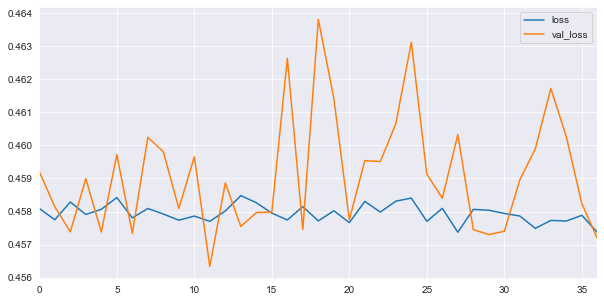

In [120]:
lossdf = pd.DataFrame(model.history.history)
lossdf.plot(figsize=(10,5))

### predictions

Gather predictions from the model

In [121]:
predictions = model.predict_classes(X_test)

W0830 14:21:16.284619 4720309696 deprecation.py:323] From <ipython-input-121-bc83193b8b59>:1: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Print the Classification Report

In [122]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89     79373
         1.0       0.54      0.01      0.01     19501

   micro avg       0.80      0.80      0.80     98874
   macro avg       0.67      0.50      0.45     98874
weighted avg       0.75      0.80      0.72     98874



Print a confusion matrix

In [123]:
# shows that the network only misclassified one point in the test data
# True Negatives, False Positives
# False Negatives, True Positives
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_test,predictions))
print('True Negatives',tn,'False Positives',fp,'False Negatives',fn,'True Positives',tp)

Confusion Matrix
[[79249   124]
 [19355   146]]
True Negatives 79249 False Positives 124 False Negatives 19355 True Positives 146


#### test against known data

grab the first index and drop the loan_status to make an X row

In [124]:
borrower = df.drop('loan_status',axis=1).iloc[0]

In [125]:
print(len(borrower), "values")
borrower.values


75 values


array([10000.0, 36.0, 11.44, 329.48, 10, 117000.0, 26.24, 16.0, 0.0,
       36369.0, 41.8, 25.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2495.0, 0, 0, 0, 0, 0, 1],
      dtype=object)

In [127]:
# scale the values
borrower.values.reshape(-1,75)

array([[10000.0, 36.0, 11.44, 329.48, 10, 117000.0, 26.24, 16.0, 0.0,
        36369.0, 41.8, 25.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2495.0, 0, 0, 0, 0, 0, 1]],
      dtype=object)

In [129]:
borrower = scaler.transform(borrower.values.reshape(-1,75))

In [ ]:
model.predict(borrower)

In [130]:
borrower_predict = model.predict(borrower)

In [131]:
borrower_actual = df['loan_status'].iloc[0]

#### what does this mean?

 In this case I'm using a metrics I made up for the home prices (continuous data) that doesn't work well with Classification Data. Need something new here to be able to test on new data and see if the predictions are making sense

In [132]:
print('actual vs predicted',borrower_actual,  borrower_predict)
#print('swing percentage',borrower_actual / borrower_predict)
#print('difference', borrower_predict - borrower_actual)

actual vs predicted 0.0 [[0.16195416]]


In [ ]:
df['loan_status'].describe()

In [133]:
# create a synthetic borrower:
borrower2 = df.drop('loan_status',axis=1).iloc[0]

In [134]:
borrower2

loan_amnt                10000
term                        36
int_rate                 11.44
installment             329.48
emp_length                  10
annual_inc              117000
dti                      26.24
open_acc                    16
pub_rec                      0
revol_bal                36369
revol_util                41.8
total_acc                   25
mort_acc                     0
pub_rec_bankruptcies         0
A                            0
B                            1
C                            0
D                            0
E                            0
F                            0
G                            0
A1                           0
A2                           0
A3                           0
A4                           0
A5                           0
B1                           0
B2                           0
B3                           0
B4                           1
                         ...  
E5                           0
F1      

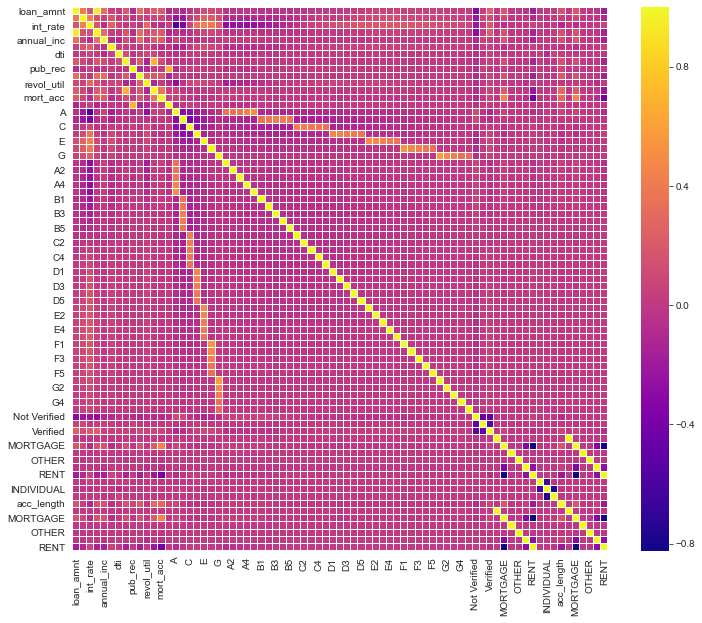

In [145]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),cmap='plasma',linewidths=.01)